In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
!pip install pytorch-metric-learning


In [2]:
import pandas as pd
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

folder = '/home/xnmaster/order_by_date/TOP15_DATAS_WITH_100_PICTURES'
all_pictures = os.listdir(folder)

file_path = "/home/xnmaster/order_by_date/TOP15_DATAS_WITH_100_PICTURES.csv"
df = pd.read_csv(file_path)

# Reemplazar el prefijo "c." con nada en la columna 'date'
#df['date'] = df['date'].str.replace('c.', '').astype('int', errors='ignore')


print(df.head())

NUM_CLASSES = len(df['date'].unique().tolist())

print("Number of classes:", NUM_CLASSES)


                  artist  date      genre  pixelsx  pixelsy  size_bytes  \
0  Ernst Ludwig Kirchner  1913  landscape   4908.0   3684.0  10682834.0   
1          Koloman Moser  1913  landscape   4716.0   3420.0  10933062.0   
2          Koloman Moser  1913  landscape   4722.0   3102.0   9018058.0   
3       Ferdinand Hodler  1913   portrait   3156.0   4638.0   8453089.0   
4          Koloman Moser  1913     design   4734.0   2622.0   8317658.0   

    source                 style  \
0  wikiart         Expressionism   
1  wikiart             Symbolism   
2  wikiart             Symbolism   
3  wikiart  Art Nouveau (Modern)   
4  wikiart  Art Nouveau (Modern)   

                                            title    artist_group  in_train  \
0                           Red Tree on the Beach  train_and_test      True   
1                                 Mountain ranges  train_and_test      True   
2                          Landscape in Semmering  train_and_test      True   
3      Valentine

In [3]:
import os
import shutil
import random
import pandas as pd


In [4]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [5]:
# GROUP THE FILES BY EACH date
import random
def group_files_per_date():
  data_per_date = {}

  # Iterate over each row of the DataFrame
  for index, row in df.iterrows():
      date = row['date']
      new_filename = row['new_filename']

      # Check if the date is already in the dictionary
      if date in data_per_date:
          # Add the new_filename to the existing list of the date
          data_per_date[date].append(new_filename)
      else:
          # Create a new list for the date and add the new_filename
          data_per_date[date] = [new_filename]

  return data_per_date

# SPLIT THE FILES INTO TRAIN AND TEST SETS (CREATE NEW DATASETS)
def split_test_train(data_per_date, train_percentage = 0.8):

  TRAIN_names = []
  TEST_names = []

  # Iterate over each date and their 'new_filename'
  for date, filenames in data_per_date.items():
      # Calculate the number of files for training and testing
      total_files = len(filenames)
      num_train = int(train_percentage * total_files)

      # Shuffle the filenames to avoid selection biases
      random.shuffle(filenames)

      # Divide the filenames into train and test
      train_filenames = filenames[:num_train]
      test_filenames = filenames[num_train:]

      # Store the divided filenames into train and test
      TRAIN_names.extend(train_filenames)
      TEST_names.extend(test_filenames)
  return TRAIN_names, TEST_names



# CREATE TEST and TRAIN folders
def create_train_test_folders(folder, TRAIN_names, TEST_names):
    # Output folder for TRAIN and TEST
    train_folder = os.path.join(folder, 'TRAIN')
    test_folder = os.path.join(folder, 'TEST')

    # Create TRAIN and TEST folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Move images from TRAIN to TRAIN folder
    for filename in TRAIN_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(train_folder, filename)
        shutil.move(src, dst)

    # Move images from TEST to TEST folder
    for filename in TEST_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(test_folder, filename)
        shutil.move(src, dst)

    # Create df_train with rows whose 'new_filename' is in TRAIN_names and keep only 'date' and 'new_filename' columns
    train_dataframe = df[df['new_filename'].isin(TRAIN_names)][['date', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'train_dataframe.csv')
    # Save the DataFrame as CSV
    train_dataframe.to_csv(file_path, index=False)

    # Create df_test with rows whose 'new_filename' is in TEST_names and keep only 'date' and 'new_filename' columns
    test_dataframe = df[df['new_filename'].isin(TEST_names)][['date', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'test_dataframe.csv')
    # Save the DataFrame as CSV
    test_dataframe.to_csv(file_path, index=False)

    return train_dataframe, test_dataframe

if not (os.path.exists(os.path.join(folder, 'TRAIN')) and os.path.exists(os.path.join(folder, 'TEST')) and os.path.exists(os.path.join(folder, 'train_dataframe.csv'))):
  # Group files per date
  data_per_date = group_files_per_date()
  # Print the number of files for each date
  print("- date and numer of images:")
  for key in data_per_date.keys():
    print(key, len(data_per_date[key]))

  # Split data
  TRAIN_names, TEST_names = split_test_train(data_per_date)

  # Use the function to create TRAIN and TEST folders
  train_dataframe, test_dataframe = create_train_test_folders(folder, TRAIN_names, TEST_names)
  print("\nImages successfully moved to TRAIN and TEST folders.")
else:
  print("TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...")

  # Read train and test DataFrames from CSV files
  train_folder = os.path.join(folder, 'TRAIN')
  test_folder = os.path.join(folder, 'TEST')

  train_images = set(os.listdir(train_folder))
  test_images = set(os.listdir(test_folder))

  train_dataframe = df[df['new_filename'].isin(train_images)].copy()
  test_dataframe = df[df['new_filename'].isin(test_images)].copy()

  train_dataframe = train_dataframe[['new_filename', 'date']]
  test_dataframe = test_dataframe[['new_filename', 'date']]

  print("Train DataFrame:", train_dataframe.shape)
  print("Test DataFrame:", test_dataframe.shape)


TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...
Train DataFrame: (1200, 2)
Test DataFrame: (300, 2)


In [6]:
test_dataframe.groupby('date').size().reset_index(name='count')

,date,count
0,1885,20
1,1888,20
2,1889,20
3,1890,20
4,1895,20
5,1907,20
6,1908,20
7,1909,20
8,1910,20
9,1911,20


In [7]:
num_valores_distintos = test_dataframe['date'].nunique()
print("Número de valores distintos en la columna 'date':", num_valores_distintos)


Número de valores distintos en la columna 'date': 15


# Model

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader

class ArtEmbeddingModel(nn.Module):
    def __init__(self):
        super(ArtEmbeddingModel, self).__init__()
        # Load pre-trained DenseNet model
        self.base_model = models.densenet121(pretrained=True)
        # Modify the classifier to output embeddings of size 128
        num_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Linear(num_features, 128)

    def forward(self, x):
        # Forward pass through the base model
        features = self.base_model(x)
        return features

def triplet_loss(anchor, positive, negative, margin=1.0):
    distance_positive = (anchor - positive).pow(2).sum(1)  # Distancia L2
    distance_negative = (anchor - negative).pow(2).sum(1)  # Distancia L2
    losses = torch.relu(distance_positive - distance_negative + margin)
    return losses.mean()




# Triplets creation functions

In [104]:
# Definir la clase TripletArtDataset
class TripletArtDataset(Dataset):
    def __init__(self, images, dates, similarity_threshold=8, transform=None):
        self.images = images
        self.dates = dates
        self.similarity_threshold = similarity_threshold
        self.transform = transform
        self.triplets = self.create_triplets()

    def create_triplets(self):
        triplets = []
        num_images = len(self.images)

        for i in range(num_images):
            anchor_image = self.images[i]
            anchor_date = self.dates[i]

            positive_indices = [j for j in range(num_images) if abs(self.dates[j] - anchor_date) <= self.similarity_threshold and j != i]
            negative_indices = [j for j in range(num_images) if abs(self.dates[j] - anchor_date) > self.similarity_threshold]

            if not positive_indices or not negative_indices:
                continue

            positive_index = np.random.choice(positive_indices)
            negative_index = np.random.choice(negative_indices)

            positive_image = self.images[positive_index]
            negative_image = self.images[negative_index]

            triplets.append((anchor_image, positive_image, negative_image))

        return triplets

    def __getitem__(self, index):
        anchor_path, positive_path, negative_path = self.triplets[index]

        try:
            anchor = Image.open(anchor_path)
            positive = Image.open(positive_path)
            negative = Image.open(negative_path)
        except FileNotFoundError as e:
            print(e)
            return None, None, None

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

    def __len__(self):
        return len(self.triplets)

# Train and Test Dataloaders

In [105]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np


# Asegúrate de que las rutas de las imágenes son completas
train_images = set(os.listdir(train_folder))
train_dataframe = df[df['new_filename'].isin(train_images)].copy()
train_dataframe = train_dataframe[['new_filename', 'date']]

# Crear una lista con las rutas completas de las imágenes
train_images_list = [os.path.join(train_folder, img) for img in train_images]

dates_train = []
for image_name in train_images:
    matching_row = train_dataframe[train_dataframe['new_filename'] == image_name]
    if not matching_row.empty:
        # Agregar la fecha correspondiente a la lista
        dates_train.append(matching_row.iloc[0]['date'])  # Asumimos que solo hay una fila que coincida
    else:
        # Manejo de casos donde no se encuentra la imagen
        dates_train.append(None)  # O cualquier otro valor indicativo de ausencia

# Convertir la lista filtrada de fechas a enteros
dates_train_int = [int(date) for date in dates_train]

print(dates_train_int)

# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])



# Crear datasets y dataloaders para entrenamiento
train_dataset = TripletArtDataset(train_images_list, dates_train_int, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)





[1907, 1914, 1911, 1890, 1890, 1890, 1914, 1889, 1909, 1888, 1885, 1913, 1912, 1915, 1914, 1890, 1912, 1890, 1907, 1890, 1895, 1917, 1910, 1911, 1911, 1907, 1911, 1889, 1915, 1907, 1917, 1910, 1908, 1885, 1885, 1911, 1889, 1890, 1889, 1912, 1885, 1911, 1910, 1885, 1890, 1917, 1885, 1914, 1895, 1909, 1889, 1885, 1889, 1911, 1889, 1889, 1908, 1912, 1910, 1890, 1915, 1912, 1890, 1914, 1890, 1909, 1911, 1888, 1889, 1889, 1913, 1895, 1909, 1907, 1917, 1915, 1913, 1913, 1910, 1885, 1910, 1911, 1908, 1917, 1913, 1911, 1914, 1889, 1914, 1915, 1913, 1917, 1889, 1888, 1910, 1910, 1917, 1915, 1915, 1885, 1910, 1907, 1911, 1915, 1895, 1890, 1890, 1888, 1913, 1908, 1908, 1915, 1914, 1913, 1895, 1917, 1890, 1910, 1885, 1885, 1912, 1888, 1915, 1895, 1910, 1913, 1911, 1890, 1913, 1888, 1907, 1910, 1909, 1908, 1913, 1890, 1885, 1888, 1888, 1912, 1888, 1911, 1913, 1885, 1917, 1917, 1915, 1889, 1909, 1889, 1907, 1913, 1908, 1890, 1890, 1889, 1888, 1910, 1895, 1917, 1895, 1914, 1912, 1909, 1913, 1914, 191

In [106]:
# Asegúrate de que las rutas de las imágenes son completas
test_images = set(os.listdir(test_folder))
test_dataframe = df[df['new_filename'].isin(test_images)].copy()
test_dataframe = test_dataframe[['new_filename', 'date']]

# Crear una lista con las rutas completas de las imágenes
test_images_list = [os.path.join(test_folder, img) for img in test_images]

dates_test = []
for image_name in test_images:
    matching_row = test_dataframe[test_dataframe['new_filename'] == image_name]
    if not matching_row.empty:
        # Agregar la fecha correspondiente a la lista
        dates_test.append(matching_row.iloc[0]['date'])  # Asumimos que solo hay una fila que coincida
    else:
        # Manejo de casos donde no se encuentra la imagen
        dates_test.append(None)  # O cualquier otro valor indicativo de ausencia

# Convertir la lista filtrada de fechas a enteros
dates_test_int = [int(date) for date in dates_test]

print(dates_test_int)

# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])



# Crear datasets y dataloaders para entrenamiento
test_dataset = TripletArtDataset(test_images_list, dates_test_int, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

[1908, 1917, 1910, 1885, 1885, 1895, 1889, 1913, 1909, 1912, 1889, 1914, 1888, 1895, 1915, 1914, 1888, 1895, 1909, 1909, 1885, 1885, 1907, 1912, 1913, 1908, 1895, 1895, 1915, 1907, 1910, 1907, 1912, 1914, 1914, 1914, 1911, 1910, 1888, 1914, 1915, 1909, 1895, 1890, 1889, 1917, 1913, 1913, 1915, 1910, 1888, 1917, 1908, 1915, 1890, 1914, 1908, 1912, 1913, 1908, 1914, 1911, 1912, 1913, 1907, 1888, 1910, 1888, 1885, 1909, 1908, 1914, 1908, 1907, 1908, 1911, 1912, 1907, 1910, 1885, 1917, 1895, 1917, 1907, 1911, 1888, 1895, 1885, 1895, 1907, 1908, 1889, 1914, 1917, 1912, 1910, 1907, 1913, 1889, 1888, 1909, 1912, 1907, 1890, 1885, 1885, 1890, 1885, 1889, 1889, 1909, 1890, 1911, 1915, 1889, 1890, 1908, 1917, 1917, 1914, 1909, 1910, 1889, 1908, 1909, 1914, 1885, 1915, 1913, 1912, 1888, 1910, 1908, 1907, 1911, 1913, 1913, 1909, 1914, 1917, 1908, 1915, 1910, 1895, 1889, 1889, 1913, 1917, 1907, 1912, 1910, 1910, 1910, 1913, 1917, 1889, 1915, 1890, 1909, 1911, 1895, 1907, 1914, 1889, 1888, 1912, 189

In [107]:
def triplet_loss_ndcg(anchor, positive, negative, margin=1.0):
    distance_positive = torch.norm(anchor - positive, p=2, dim=1)
    distance_negative = torch.norm(anchor - negative, p=2, dim=1)
    
    diff = distance_negative - distance_positive
    losses = torch.relu(diff + margin)
    
    dcg = torch.sum((2**(1/distance_positive) - 1) / torch.log2(torch.arange(2, 2 + len(distance_positive)).float().to(device)))
    idcg = torch.sum((2**(1/torch.sort(distance_positive, descending=False).values) - 1) / torch.log2(torch.arange(2, 2 + len(distance_positive)).float().to(device)))
    
    ndcg = dcg / idcg
    return losses.mean() * (1 - ndcg.mean())



## ENTRENAMENT DEL MODEL

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


class ArtEmbeddingModel(nn.Module):
    def __init__(self, base_model):
        super(ArtEmbeddingModel, self).__init__()
        self.base_model = base_model
        if isinstance(base_model, models.DenseNet):
            num_features = self.base_model.classifier.in_features
            self.base_model.classifier = nn.Linear(num_features, 128)
        elif isinstance(base_model, models.ResNet):
            num_features = self.base_model.fc.in_features
            self.base_model.fc = nn.Linear(num_features, 128)
        elif isinstance(base_model, models.MobileNetV2):
            num_features = self.base_model.classifier[1].in_features
            self.base_model.classifier = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(num_features, 128)
            )

    def forward(self, x):
        return self.base_model(x)

# Instantiate different base models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = ArtEmbeddingModel(models.densenet121(pretrained=True)).to(device)
model2 = ArtEmbeddingModel(models.resnet50(pretrained=True)).to(device)
model3 = ArtEmbeddingModel(models.mobilenet_v2(pretrained=True)).to(device)

# Define a training loop function
def train_model(model, train_dataloader, num_epochs):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(num_epochs):
        model.train()
        for anchors, positives, negatives in train_dataloader:
            anchors = anchors.to(device)
            positives = positives.to(device)
            negatives = negatives.to(device)

            optimizer.zero_grad()
            torch.cuda.empty_cache()
            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)

            loss = triplet_loss_ndcg(anchor_embeddings, positive_embeddings, negative_embeddings)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Train the models
train_model(model1, train_dataloader, num_epochs=10)
train_model(model2, train_dataloader, num_epochs=10)
train_model(model3, train_dataloader, num_epochs=10)


Epoch 1, Loss: 0.7374722957611084
Epoch 2, Loss: 0.1428423523902893
Epoch 3, Loss: 1.3061532974243164
Epoch 4, Loss: 0.030608544126152992
Epoch 5, Loss: 0.1211586594581604
Epoch 6, Loss: 0.005448456387966871
Epoch 7, Loss: 0.029186110943555832
Epoch 8, Loss: 0.12735648453235626
Epoch 9, Loss: 0.011372819542884827
Epoch 10, Loss: 0.3996981382369995
Epoch 1, Loss: 0.5996056795120239
Epoch 2, Loss: 0.10484250634908676
Epoch 3, Loss: 0.18905961513519287
Epoch 4, Loss: 0.015843959525227547
Epoch 5, Loss: 0.04221459850668907
Epoch 6, Loss: 0.20192304253578186
Epoch 7, Loss: 0.011803834699094296
Epoch 8, Loss: 0.565488338470459
Epoch 9, Loss: 0.12222547829151154
Epoch 10, Loss: 0.009505159221589565
Epoch 1, Loss: 0.2354663759469986
Epoch 2, Loss: 0.09804563969373703
Epoch 3, Loss: 0.15954333543777466
Epoch 4, Loss: 0.05936751142144203
Epoch 5, Loss: 0.02531249262392521
Epoch 6, Loss: 0.08386378735303879
Epoch 7, Loss: 0.08644826710224152
Epoch 8, Loss: 0.07740779966115952
Epoch 9, Loss: 0.014

## EVALUATE THE MODEL

In [115]:
def calculate_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for anchors, positives, negatives in dataloader:
            anchors = anchors.to(device)
            embeddings.append(model(anchors).cpu())
            labels.append(anchors.cpu())

    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels

# Calculate embeddings for each model
train_embeddings1, labels1 = calculate_embeddings(model1, train_dataloader, device)
test_embeddings1, _ = calculate_embeddings(model1, test_dataloader, device)
train_embeddings2, _ = calculate_embeddings(model2, train_dataloader, device)
test_embeddings2, _ = calculate_embeddings(model2, test_dataloader, device)
train_embeddings3, _ = calculate_embeddings(model3, train_dataloader, device)
test_embeddings3, _ = calculate_embeddings(model3, test_dataloader, device)


In [121]:
print(train_embeddings_combined.shape)

(1200, 384)


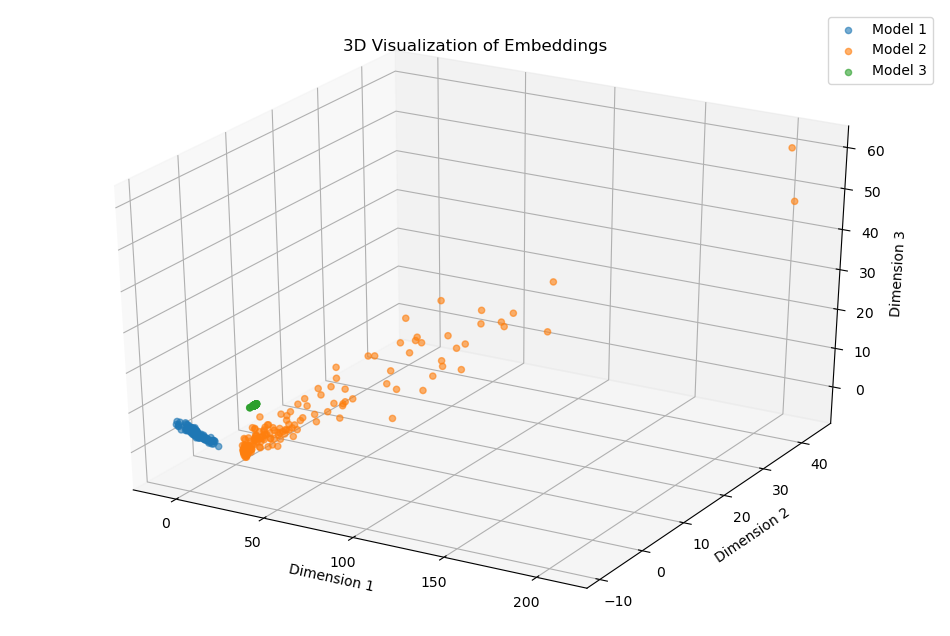

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Concatenate embeddings for visualization
all_embeddings = np.vstack((train_embeddings1, train_embeddings2, train_embeddings3))
labels = np.array(['Model 1'] * len(train_embeddings1) + ['Model 2'] * len(train_embeddings2) + ['Model 3'] * len(train_embeddings3))

# Use t-SNE for dimensionality reduction to 3D
# tsne = TSNE(n_components=3, random_state=42)
# embeddings_3d = tsne.fit_transform(all_embeddings)

# Alternatively, you can use PCA for dimensionality reduction to 3D
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(all_embeddings)

# Plot the 3D embeddings
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
for label in np.unique(labels):
    idx = labels == label
    ax.scatter(embeddings_3d[idx, 0], embeddings_3d[idx, 1], embeddings_3d[idx, 2], label=label, alpha=0.6)

ax.set_title('3D Visualization of Embeddings')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.legend()
plt.show()



In [110]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score for the combined embeddings
sil_score = silhouette_score(embeddings_3d, labels)
print(f'Silhouette Score: {sil_score}')

Silhouette Score: 0.9165477752685547


In [47]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Combine embeddings
train_embeddings_combined = np.hstack((train_embeddings1, train_embeddings2, train_embeddings3))
test_embeddings_combined = np.hstack((test_embeddings1, test_embeddings2, test_embeddings3))

# Assuming dates_train_int and dates_test_int contain the actual continuous labels for training and testing
train_labels = np.array(dates_train_int)
test_labels = np.array(dates_test_int)

# Train a RandomForestRegressor as the meta-learner with tuned parameters
meta_learner = RandomForestRegressor(
    n_estimators=200,     # Number of trees in the forest
    max_depth= 10,         # Maximum depth of the tree
    min_samples_split=3,  # Minimum number of samples required to split an internal node
    min_samples_leaf=2,   # Minimum number of samples required to be at a leaf node
    random_state=42       # Seed for reproducibility
)
meta_learner.fit(train_embeddings_combined, train_labels)

# Predict the labels for the test set
test_predictions = meta_learner.predict(test_embeddings_combined)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(test_labels, test_predictions)
print("Mean Absolute Error (MAE): {:.2f}".format(mae))

Mean Absolute Error (MAE): 9.96


In [134]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR  # Support Vector Regression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# Combine embeddings
train_embeddings_combined = np.hstack((train_embeddings1, train_embeddings2, train_embeddings3))
test_embeddings_combined = np.hstack((test_embeddings1, test_embeddings2, test_embeddings3))

# Assuming dates_train_int and dates_test_int contain the actual continuous labels for training and testing
train_labels = np.array(dates_train_int)
test_labels = np.array(dates_test_int)

# Train a RandomForestRegressor as the meta-learner with tuned parameters
meta_learner = SVR()
meta_learner.fit(train_embeddings_combined, train_labels)

# Predict the labels for the test set
test_predictions = meta_learner.predict(test_embeddings_combined)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(test_labels, test_predictions)
print("Mean Absolute Error (MAE): {:.2f}".format(mae))

Mean Absolute Error (MAE): 8.69


In [135]:
tolerance = 3

# Calculate custom accuracy
accurate_predictions = np.abs(test_predictions - test_labels) <= tolerance
accuracy = np.mean(accurate_predictions) * 100
print("Accuracy: {:.2f}%".format(accuracy))

Accuracy: 34.00%


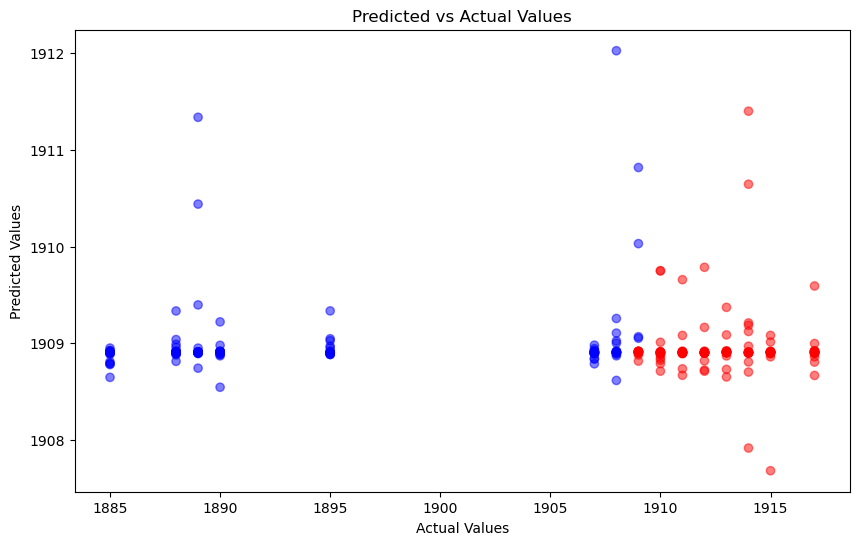

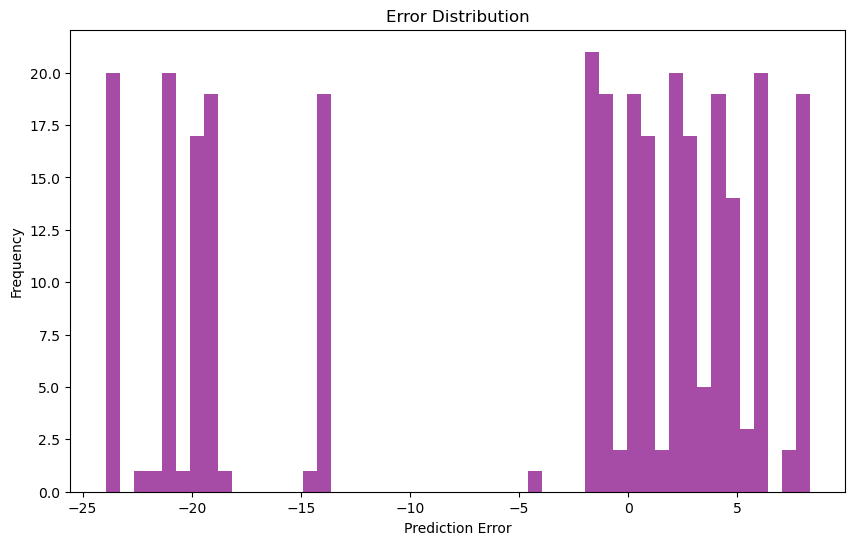

In [136]:
import matplotlib.pyplot as plt

# Calculate errors
errors = test_labels - test_predictions

# Plot predicted vs actual values with conditional coloring
plt.figure(figsize=(10, 6))
colors = ['red' if error > 0 else 'blue' for error in errors]
plt.scatter(test_labels, test_predictions, c=colors, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, color='purple', alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.show()


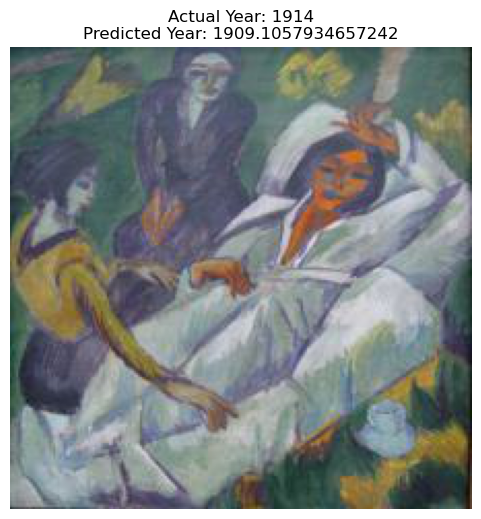

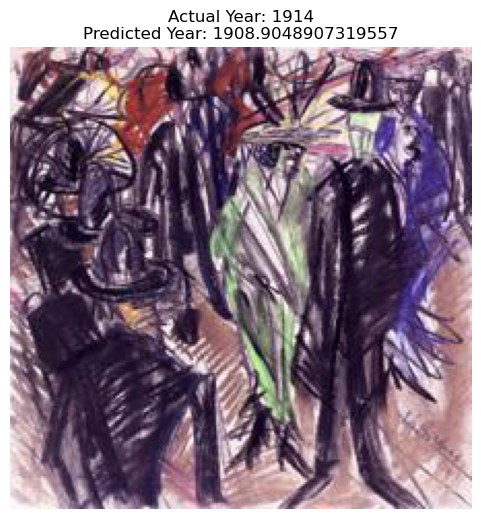

In [138]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

# Function to load an image from a path
def load_image(image_path):
    return Image.open(image_path)

# Function to get the prediction for a single image
def get_prediction_for_image(image_path, model, device):
    # Load and preprocess the image
    image = load_image(image_path)
    image = image.resize((224, 224))  # Resize to the input size expected by the model
    image = np.array(image) / 255.0  # Normalize pixel values
    image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()  # Convert to tensor and add batch dimension

    # Move to the appropriate device
    image = image.to(device)

    # Get the embedding
    with torch.no_grad():
        model.eval()
        embedding = model(image)

    return embedding.cpu().numpy()

test_images_prova = [test_folder+"/2576.jpg", test_folder+"/9681.jpg"]  
dates_test_int_prova = [1914, 1914]  

# Get the embeddings for all test images
test_embeddings = [get_prediction_for_image(path, model3, device) for path in test_images_prova]
test_embeddings = np.vstack(test_embeddings)


meta_learner = SVR()
meta_learner.fit(train_embeddings_combined, train_labels)


# Predict the years for the test set
predicted_years = meta_learner.predict(test_embeddings_combined)

# Plotting a single example
def plot_prediction_example(image_path, actual_year, predicted_year):
    img = load_image(image_path)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual Year: {actual_year}\nPredicted Year: {predicted_year}")
    plt.show()


for i in range(len(test_images_prova)):
    plot_prediction_example(test_images_prova[i], dates_test_int_prova[i], predicted_years[i])
